In [12]:
import pandas as pd
from tabulate import tabulate
from datetime import datetime
import re
# input CSV file

df = pd.read_csv("fifa21_raw_data.csv")

C:\Users\HP\AppData\Local\Temp\ipykernel_15220\2993286264.py:7: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("fifa21_raw_data.csv")


In [ ]:
def convert_height(height):
    feet, inches = height.split("'")
    inches = inches.replace('"', '')
    return int(feet) * 12 + int(inches)

df["Height"] = df["Height"].apply(convert_height)

df["Weight"] = df["Weight"].str.replace("lbs","").astype(int)


print(df["Height"],df["Weight"])

In [ ]:

df["Team & Contract"] = df["Team & Contract"].astype(str).str[4:-2]

df["Hits"] = df["Hits"].astype(str).str[1:]

print(df["Team & Contract"],df["Hits"])

In [ ]:
# Step 1: Convert the 'joined' column to datetime format
df['Joined'] = pd.to_datetime(df['Joined'], format='%b %d, %Y')

# Step 2: Calculate the duration in years
current_date = datetime.now()
df['years_in_team'] = (current_date - df['Joined']).dt.days / 365.25

# Step 3: Filter players who have been in the team for more than 10 years
long_term_players = df[df['years_in_team'] > 10]

print(long_term_players["LongName"])



In [15]:
def contains_euro(x):
    return '€' in str(x)

# Apply the function to each column and then use any to find columns with '*'
columns_with_euro = df.applymap(contains_euro).any()

# Get column names that contain '€'
columns_with_euro = columns_with_euro[columns_with_euro].index.tolist()

def convert_to_numeric(value):
    # Remove the Euro sign in front
    value = value.replace('€', '')
    if 'K' in value:
        return f"€{float(value.replace('K', '')) * 1_000:,.0f}"
    elif 'M' in value:
        return f"€{float(value.replace('M', '')) * 1_000_000:,.0f}"
    return f"€{float(value):,.0f}"


df[columns_with_euro] = df[columns_with_euro].applymap(convert_to_numeric)


print(df[columns_with_euro])

In [16]:
def contains_star(x):
    return '★' in str(x)

# Apply the function to each column and then use any to find columns with '★'
columns_with_star = df.applymap(contains_star).any()

# Get column names that contain '★'
columns_with_star = columns_with_star[columns_with_star].index.tolist()

df[columns_with_star] = df[columns_with_star].applymap(lambda x: x.replace("★", ""))


print(df[columns_with_star])

C:\Users\HP\AppData\Local\Temp\ipykernel_15220\486461985.py:8: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("fifa21_raw_data.csv")


+---+----------------+-----------+--------+--------------------+---------------------+
|   |      Name      |   Value   |  Wage  |   Predicted_Wage   |      Residual       |
+---+----------------+-----------+--------+--------------------+---------------------+
| 2 |    J. Oblak    | 75000000  | 125000 | 245317.89381959414 | -120317.89381959414 |
| 4 |   Neymar Jr    | 90000000  | 270000 | 294071.1633513402  | -24071.16335134022  |
| 5 | R. Lewandowski | 80000000  | 240000 | 261568.98366350948 | -21568.983663509483 |
| 6 |   K. Mbappé    | 105500000 | 160000 | 344449.5418674778  | -184449.54186747782 |
| 7 |    Alisson     | 62500000  | 160000 | 204690.16920980575 | -44690.169209805754 |
+---+----------------+-----------+--------+--------------------+---------------------+


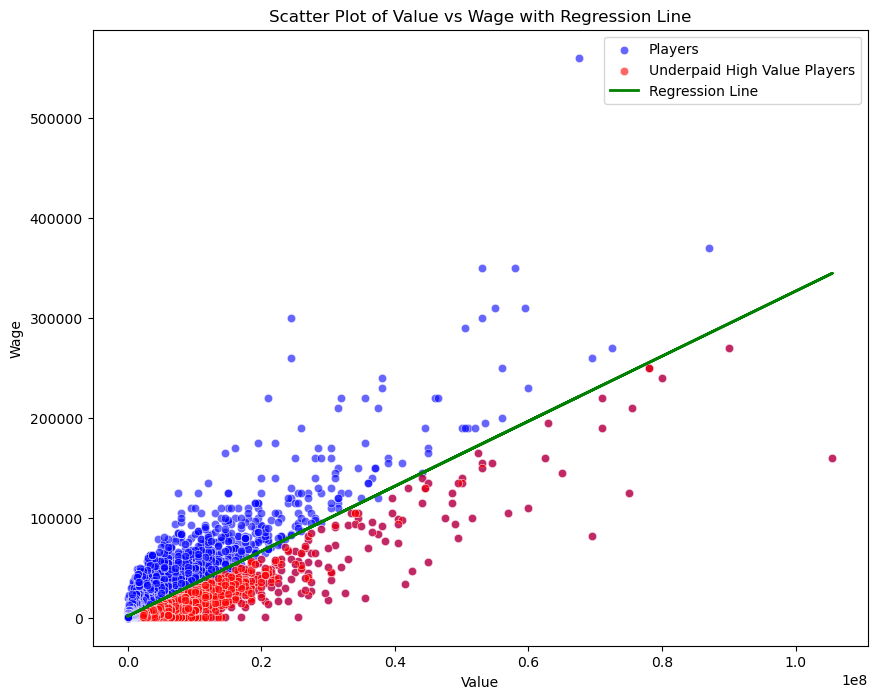

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tabulate import tabulate

# Read the data
data = pd.read_csv("fifa21_raw_data.csv")
df = pd.DataFrame(data)

# Function to convert the values
def convert_currency(value):
    value = value.replace('€', '')  # Remove the euro symbol
    if 'M' in value:
        return int(float(value.replace('M', '')) * 1_000_000)
    elif 'K' in value:
        return int(float(value.replace('K', '')) * 1_000)
    else:
        return int(float(value))  # In case there are no M or K suffixes

# Apply the function to the relevant columns
df['Value'] = df['Value'].apply(convert_currency)
df['Wage'] = df['Wage'].apply(convert_currency)

# Fit a linear regression model
X = df[['Value']]
y = df['Wage']
reg = LinearRegression().fit(X, y)

# Predict wages based on the model
df['Predicted_Wage'] = reg.predict(X)

# Calculate residuals (actual wage - predicted wage)
df['Residual'] = df['Wage'] - df['Predicted_Wage']

# Define a threshold for "underpaid"
# For example, we can use players whose residual is in the lowest 10% as underpaid
threshold = np.percentile(df['Residual'], 10)
underpaid_high_value_players = df[(df['Residual'] < threshold) & (df['Value'] > df['Value'].mean())]

# Print the filtered results
print(tabulate(underpaid_high_value_players[['Name', 'Value', 'Wage', 'Predicted_Wage', 'Residual']].head(), headers='keys', tablefmt='pretty'))

# Plotting the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Value'], df['Wage'], color='blue', alpha=0.6, edgecolors='w', linewidth=0.5, label='Players')
plt.scatter(underpaid_high_value_players['Value'], underpaid_high_value_players['Wage'], color='red', alpha=0.6, edgecolors='w', linewidth=0.5, label='Underpaid High Value Players')
plt.plot(df['Value'], df['Predicted_Wage'], color='green', linewidth=2, label='Regression Line')

# Adding title and labels
plt.title('Scatter Plot of Value vs Wage with Regression Line')
plt.xlabel('Value')
plt.ylabel('Wage')
plt.legend()

# Show plot
plt.show()
